# Initialize Colab Environment

**Note 1: Sometimes the colab notebook runtimes 'break' and you get runtime errors for no reason. In these cases, restart the runtime by clicking 'Runtime' -> 'Restart Runtime' and run everything in this section again.**

**Note 2: If you care about speed, make sure your colab runtime uses a GPU. Do this by selecting 'Runtime' -> 'Change Runtime Type' -> 'Hardware Accelerator' -> 'GPU' (the runtime will restart and you'll have to re-run this section).**

We're going to mount your Google Drive first, using the command below. Just follow the prompts.

In [1]:
from google.colab import drive
drive.mount("/content/drive")

ValueError: mount failed

Next, we're going to change the directory to your drive, and make a folder for the tutorial. If any of these steps has been done before, it will simply be skipped (and throw an error message, which you can ignore).

In [ ]:
%cd ~
%cd /content/drive/My\ Drive/
%mkdir wgan-tutorial
%cd wgan-tutorial

#eventually put our replication repo here
#!git clone https://github.com/gsbDBI/ds-wgan/

Next, install the wgan package written for the project:

In [ ]:
!pip3 uninstall wgan
!pip3 install git+https://github.com/gsbDBI/ds-wgan.git@package#egg=wgan

Uninstalling wgan-0.2:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/wgan-0.2.dist-info/*
    /usr/local/lib/python3.6/dist-packages/wgan/*
Proceed (y/n)? y
  Successfully uninstalled wgan-0.2
  Cloning https://github.com/gsbDBI/ds-wgan.git (to revision package) to /tmp/pip-install-yua2epk6/wgan
  Running command git clone -q https://github.com/gsbDBI/ds-wgan.git /tmp/pip-install-yua2epk6/wgan
  Running command git checkout -b package --track origin/package
  Switched to a new branch 'package'
  Branch 'package' set up to track remote branch 'package' from 'origin'.
  Created wheel for wgan: filename=wgan-0.2-cp36-none-any.whl size=10211 sha256=3a9201d30c907f003e2bf679f676a8610c14bc40835b997e078af45bfaff470b
  Stored in directory: /tmp/pip-ephem-wheel-cache-sxztppjz/wheels/f5/2d/c5/7f89b462ba77f243e888bd45ed0c8eef94c51184249e54e4d7
Successfully built wgan


# Simulating Data

The workflow for every single distribution you want to fit:

0.   Load and prepare the data
1.   Initialize a `wgan.DataWrapper` object, which takes care of handling the data
2.   Initialize `wgan.Specifications` object given the `DataWrapper`, which summarizes hyperparameters, etc.
3.   Initialize `wgan.Generator` & `wgan.Critic` given the `Specifications`
4.   Preprocess the data with the `DataWrapper` object
5.   Train the `Generator` & `Critic` via `wgan.train`
6.   Replace columns in df with simulated data from `Generator` using `DataWrapper.apply_generator`
7.   If you're interested in them, add the `Critic` outputs to the original and/or the generated df via `DataWrapper.apply_critic`
7.   Explore the data via `compare_dfs` & save the new data.

Since **we're fitting two distributions** (Y on X and t, as well as X on t), we'll have to do all these steps twice.
To keep the code concise, we will put the two versions of every obejct type into one list respectively. Watch out so you **don't get confused by that**!


## Steps 0-3

First load a data file from our project repo

In [ ]:
import pandas as pd
import wgan
import io
import requests


resp = requests.get(
    'https://raw.github.com/gsbDBI/ds-wgan/master/data/original_data/cps.feather',
    stream=True
)
resp.raw.decode_content = True
mem_fh = io.BytesIO(resp.raw.read())
df = pd.read_feather(mem_fh).drop(["u74","u75"],axis=1)

After loading in our data as `df`, we will build from it second dataframe called `df_balanced`, by sampling treated and controls with similar probability from `df`. We will train our WGAN on `df_balanced`, which makes sure the quality of the generated outcomes is similar for both treatment groups.



In [ ]:
df_balanced = df.sample(2*len(df), weights=(1-df.t.mean())*df.t+df.t.mean()*(1-df.t), replace=True) # balanced df for training

# X | t
continuous_vars_0 = ["age", "education", "re74", "re75"]
continuous_lower_bounds_0 = {"re74": 0, "re75": 0}
categorical_vars_0 = ["black", "hispanic", "married", "nodegree"]
context_vars_0 = ["t"]

# Y | X, t
continuous_vars_1 = ["re78"]
continuous_lower_bounds_1 = {"re78": 0}
categorical_vars_1 = []
context_vars_1 = ["t", "age", "education", "re74", "re75", "black", "hispanic", "married", "nodegree"]

# Initialize objects
data_wrappers = [wgan.DataWrapper(df_balanced, continuous_vars_0, categorical_vars_0,
                                  context_vars_0, continuous_lower_bounds_0),
                 wgan.DataWrapper(df_balanced, continuous_vars_1, categorical_vars_1,
                                  context_vars_1, continuous_lower_bounds_1)]
specs = [wgan.Specifications(dw, batch_size=4096, max_epochs=1000, critic_lr=1e-3, generator_lr=1e-3,
                             print_every=100, device = "cuda") for dw in data_wrappers]
generators = [wgan.Generator(spec) for spec in specs]
critics = [wgan.Critic(spec) for spec in specs]

settings: {'device': 'cuda', 'print_every': 100, 'save_every': 100, 'save_checkpoint': None, 'load_checkpoint': None, 'test_set_size': 16, 'batch_size': 4096, 'max_epochs': 1000, 'optimizer': <class 'torch.optim.adam.Adam'>, 'gaussian_similarity_penalty': None, 'generator_d_noise': 12, 'generator_lr': 0.001, 'generator_dropout': 0.1, 'generator_d_hidden': [128, 128, 128], 'critic_gp_factor': 5, 'critic_lr': 0.001, 'critic_steps': 15, 'critic_dropout': 0, 'critic_d_hidden': [128, 128, 128]}
settings: {'device': 'cuda', 'print_every': 100, 'save_every': 100, 'save_checkpoint': None, 'load_checkpoint': None, 'test_set_size': 16, 'batch_size': 4096, 'max_epochs': 1000, 'optimizer': <class 'torch.optim.adam.Adam'>, 'gaussian_similarity_penalty': None, 'generator_d_noise': 1, 'generator_lr': 0.001, 'generator_dropout': 0.1, 'generator_d_hidden': [128, 128, 128], 'critic_gp_factor': 5, 'critic_lr': 0.001, 'critic_steps': 15, 'critic_dropout': 0, 'critic_d_hidden': [128, 128, 128]}


## Steps 4 & 5

Next, we train the model. How long this will take depends on the batch_size, the size of your data set and the max_epochs you specified.

You can also abort at any time, the model will keep its parameters at their most recent values during training. You can also resume the training, but this resets the optimizer state which basically means you might as well repeat at Step 3.

In [ ]:
# train X | t
x, context = data_wrappers[0].preprocess(df_balanced)
wgan.train(generators[0], critics[0], x, context, specs[0])

epoch 0 | step 9 | WD_test 0.3 | WD_train 0.11 | sec passed 10 |
epoch 100 | step 809 | WD_test 0.86 | WD_train 0.72 | sec passed 31 |
epoch 200 | step 1609 | WD_test 0.58 | WD_train 0.55 | sec passed 31 |
epoch 300 | step 2409 | WD_test 0.51 | WD_train 0.48 | sec passed 31 |
epoch 400 | step 3209 | WD_test 0.54 | WD_train 0.42 | sec passed 31 |
epoch 500 | step 4009 | WD_test 0.13 | WD_train 0.37 | sec passed 31 |
epoch 600 | step 4809 | WD_test 0.52 | WD_train 0.39 | sec passed 32 |
epoch 700 | step 5609 | WD_test 0.42 | WD_train 0.39 | sec passed 32 |
epoch 800 | step 6409 | WD_test 0.09 | WD_train 0.35 | sec passed 32 |
epoch 900 | step 7209 | WD_test 0.49 | WD_train 0.35 | sec passed 32 |


In [ ]:
# train Y | X, t
x, context = data_wrappers[1].preprocess(df_balanced)
wgan.train(generators[1], critics[1], x, context, specs[1])

epoch 0 | step 9 | WD_test 0.16 | WD_train 0.05 | sec passed 0 |
epoch 100 | step 809 | WD_test 0.01 | WD_train 0.27 | sec passed 31 |
epoch 200 | step 1609 | WD_test 0.15 | WD_train 0.21 | sec passed 31 |
epoch 300 | step 2409 | WD_test 0.34 | WD_train 0.18 | sec passed 31 |
epoch 400 | step 3209 | WD_test 0.16 | WD_train 0.22 | sec passed 31 |
epoch 500 | step 4009 | WD_test 0.25 | WD_train 0.24 | sec passed 31 |
epoch 600 | step 4809 | WD_test 0.42 | WD_train 0.26 | sec passed 31 |
epoch 700 | step 5609 | WD_test 0.14 | WD_train 0.26 | sec passed 31 |
epoch 800 | step 6409 | WD_test 0.18 | WD_train 0.23 | sec passed 31 |
epoch 900 | step 7209 | WD_test 0.31 | WD_train 0.23 | sec passed 31 |


## Steps 6 & 8

In [ ]:
# simulate data with conditional WGANs
df_generated = data_wrappers[0].apply_generator(generators[0], df.sample(int(1e6), replace=True))
df_generated = data_wrappers[1].apply_generator(generators[1], df_generated)


# add counterfactual outcomes
from copy import copy
df_generated_cf = copy(df_generated)
df_generated_cf["t"] = 1 - df_generated_cf["t"]
df_generated["re78_cf"] = data_wrappers[1].apply_generator(generators[1], df_generated_cf)["re78"]

# save to .feather
#df_generated.to_feather("data/generated/{}_generated.feather".format(name))

att: -572.4760763184237
-------------comparison of means-------------
t               0.0                1.0         
source         fake      real     fake     real
age           32.24     33.23    25.04    25.82
education     11.99     12.03    10.35    10.35
black          0.07      0.07     0.86     0.84
hispanic       0.05      0.07     0.06     0.06
married        0.71      0.71     0.16     0.19
nodegree       0.30      0.30     0.70     0.71
re74       13684.51  14016.80  1954.66  2095.57
re75       13561.16  13650.80  1060.05  1532.06
re78       15149.37  14846.66  4456.00  6349.14
-------------comparison of stds-------------
t              0.0               1.0         
source        fake     real     fake     real
age          10.88    11.05     7.09     7.16
education     2.87     2.87     2.05     2.01
black         0.26     0.26     0.35     0.36
hispanic      0.22     0.26     0.23     0.24
married       0.45     0.45     0.37     0.39
nodegree      0.46     0.46     0.4

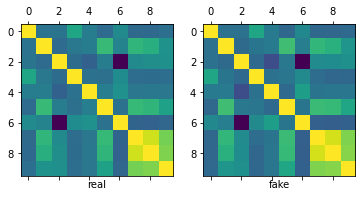

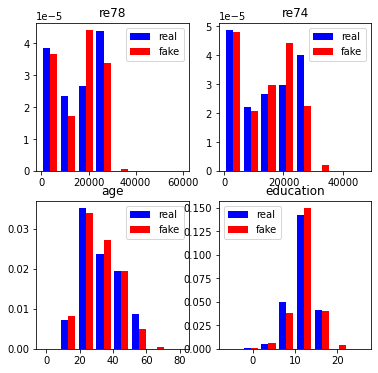

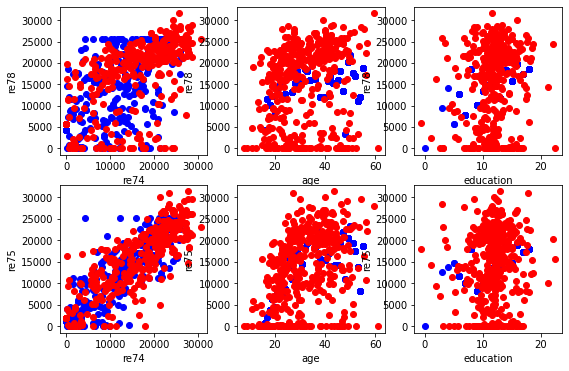

In [ ]:
print("att:", ((df_generated.re78-df_generated.re78_cf) * (2*df_generated.t - 1))[df_generated.t==1].mean())
wgan.compare_dfs(df, df_generated,
                 scatterplot=dict(x=["re74", "age", "education"], y=["re78", "re75"], samples=400, smooth=0),
                 table_groupby=["t"],
                 histogram=dict(variables=["re78", "re74", "age", "education"], nrow=2, ncol=2),
                 figsize=3)